# Importing Dataset and Packages

In [1]:
import pandas as pd
from hdfs import InsecureClient
import os
from pyspark.sql import SparkSession
import matplotlib.pyplot as plt
import seaborn as sns
import simplejson as json
import numpy as np

In [2]:
sparkSession = SparkSession.builder.appName("Assignment").getOrCreate() #Sparksession Create to connect to HDFS
client_hdfs = InsecureClient('hdfs://localhost:9820')

In [3]:
df = sparkSession.read.text('hdfs://localhost:9820/test/transactions.txt')#Dataset Imported from HDFS
df.show()

+--------------------+
|               value|
+--------------------+
|{"accountNumber":...|
|{"accountNumber":...|
|{"accountNumber":...|
|{"accountNumber":...|
|{"accountNumber":...|
|{"accountNumber":...|
|{"accountNumber":...|
|{"accountNumber":...|
|{"accountNumber":...|
|{"accountNumber":...|
|{"accountNumber":...|
|{"accountNumber":...|
|{"accountNumber":...|
|{"accountNumber":...|
|{"accountNumber":...|
|{"accountNumber":...|
|{"accountNumber":...|
|{"accountNumber":...|
|{"accountNumber":...|
|{"accountNumber":...|
+--------------------+
only showing top 20 rows



In [4]:
result_df = df.select("*").toPandas()#Converted to pandas dataframe
result_df.head()

,value
0,"{""accountNumber"": ""737265056"", ""customerId"": ""..."
1,"{""accountNumber"": ""737265056"", ""customerId"": ""..."
2,"{""accountNumber"": ""737265056"", ""customerId"": ""..."
3,"{""accountNumber"": ""737265056"", ""customerId"": ""..."
4,"{""accountNumber"": ""830329091"", ""customerId"": ""..."


In [5]:
result_df = result_df['value'].apply(json.loads)#Transformed from json format to csv format

In [6]:
result_df = pd.DataFrame(result_df.tolist())

In [7]:
result_df.head()

,accountNumber,customerId,creditLimit,availableMoney,transactionDateTime,transactionAmount,merchantName,acqCountry,merchantCountryCode,posEntryMode,...,echoBuffer,currentBalance,merchantCity,merchantState,merchantZip,cardPresent,posOnPremises,recurringAuthInd,expirationDateKeyInMatch,isFraud
0,737265056,737265056,5000.0,5000.0,2016-08-13T14:27:32,98.55,Uber,US,US,02,...,,0.0,,,,False,,,False,False
1,737265056,737265056,5000.0,5000.0,2016-10-11T05:05:54,74.51,AMC #191138,US,US,09,...,,0.0,,,,True,,,False,False
2,737265056,737265056,5000.0,5000.0,2016-11-08T09:18:39,7.47,Play Store,US,US,09,...,,0.0,,,,False,,,False,False
3,737265056,737265056,5000.0,5000.0,2016-12-10T02:14:50,7.47,Play Store,US,US,09,...,,0.0,,,,False,,,False,False
4,830329091,830329091,5000.0,5000.0,2016-03-24T21:04:46,71.18,Tim Hortons #947751,US,US,02,...,,0.0,,,,True,,,False,False


In [8]:
#Identifying Data type and Checking null values, missing values.
print(result_df.dtypes)
print(result_df.isnull().any())
print(result_df.isnull().sum())
print(result_df.eq('').sum())
print(result_df.shape)

accountNumber                object
customerId                   object
creditLimit                 float64
availableMoney              float64
transactionDateTime          object
transactionAmount           float64
merchantName                 object
acqCountry                   object
merchantCountryCode          object
posEntryMode                 object
posConditionCode             object
merchantCategoryCode         object
currentExpDate               object
accountOpenDate              object
dateOfLastAddressChange      object
cardCVV                      object
enteredCVV                   object
cardLast4Digits              object
transactionType              object
echoBuffer                   object
currentBalance              float64
merchantCity                 object
merchantState                object
merchantZip                  object
cardPresent                    bool
posOnPremises                object
recurringAuthInd             object
expirationDateKeyInMatch    

In [9]:
#Checking for columns with integer to convert data type from object to int
def hasNumbers(inputString):
        return any(char.isdigit() for char in inputString)

for col in result_df.columns: 
    if(result_df[col].dtype == object and hasNumbers(result_df[col]) == True):
        result_df[col] = pd.to_numeric(result_df[col])
result_df = result_df.dropna()

In [10]:
#Extracting unique values from dataset
for col in result_df.columns:
    if(result_df[col].nunique() <= 5):
        print(result_df[col].value_counts())

US     770305
         4540
MEX      3116
CAN      2409
PR       1533
Name: acqCountry, dtype: int64
US     774090
MEX      3129
CAN      2411
PR       1554
          719
Name: merchantCountryCode, dtype: int64
5.0     314850
9.0     236386
2.0     195835
90.0     19558
80.0     15274
Name: posEntryMode, dtype: int64
1.0     625483
8.0     148941
99.0      7479
Name: posConditionCode, dtype: int64
PURCHASE                740944
REVERSAL                 20187
ADDRESS_VERIFICATION     20076
                           696
Name: transactionType, dtype: int64
    781903
Name: echoBuffer, dtype: int64
    781903
Name: merchantCity, dtype: int64
    781903
Name: merchantState, dtype: int64
    781903
Name: merchantZip, dtype: int64
False    431014
True     350889
Name: cardPresent, dtype: int64
    781903
Name: posOnPremises, dtype: int64
    781903
Name: recurringAuthInd, dtype: int64
False    780865
True       1038
Name: expirationDateKeyInMatch, dtype: int64
False    769776
True      12127

In [11]:
#Data mutation for acqCountry 
result_df['acqCountry'] = np.where((result_df['merchantCountryCode'].eq('US')) & ((result_df['acqCountry'].eq(''))),'US',result_df['acqCountry'])

In [12]:
result_df.isFraud.value_counts()

False    769776
True      12127
Name: isFraud, dtype: int64

In [13]:
#Extracting each attribute from date time column and creating new column
result_df['transactionDateTime'] = pd.to_datetime(result_df['transactionDateTime'], errors='coerce')
result_df['transaction_year'] = result_df['transactionDateTime'].dt.year
result_df['transaction_month'] = result_df['transactionDateTime'].dt.month
result_df['transaction_week'] = result_df['transactionDateTime'].dt.week
result_df['transaction_day'] = result_df['transactionDateTime'].dt.day
result_df['transaction_hour'] = result_df['transactionDateTime'].dt.hour
result_df['transaction_minute'] = result_df['transactionDateTime'].dt.minute

<ipython-input-13-1cf961da5bcf>:5: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  result_df['transaction_week'] = result_df['transactionDateTime'].dt.week


In [14]:
print(result_df['transactionDateTime'])

0        2016-08-13 14:27:32
1        2016-10-11 05:05:54
2        2016-11-08 09:18:39
3        2016-12-10 02:14:50
4        2016-03-24 21:04:46
                 ...        
786358   2016-12-22 18:44:12
786359   2016-12-25 16:20:34
786360   2016-12-27 15:46:24
786361   2016-12-29 00:30:55
786362   2016-12-30 20:10:29
Name: transactionDateTime, Length: 781903, dtype: datetime64[ns]


In [15]:
#Extracting duplicate transactions
Duplicated = (result_df.sort_values(['transactionDateTime']).groupby(['accountNumber', 'transactionAmount'], sort=False)['transactionDateTime'].diff().dt.total_seconds().lt(600))

In [16]:
Duplicated.value_counts()

False    768557
True      13346
Name: transactionDateTime, dtype: int64

In [17]:
result_df['multiswipe'] = Duplicated

In [18]:
#Extracting reversal transactions
result_df['reversal'] = np.where(result_df['transactionType'] == 'REVERSAL', True, False)

In [19]:
result_df['reversal'].value_counts()

False    761716
True      20187
Name: reversal, dtype: int64

In [20]:
result_df.describe()

,accountNumber,customerId,creditLimit,availableMoney,transactionAmount,posEntryMode,posConditionCode,cardCVV,enteredCVV,cardLast4Digits,currentBalance,transaction_year,transaction_month,transaction_week,transaction_day,transaction_hour,transaction_minute
count,7.819030e+05,7.819030e+05,781903.000000,781903.000000,781903.000000,781903.000000,781903.000000,781903.000000,781903.000000,781903.000000,781903.000000,781903.0,781903.000000,781903.000000,781903.000000,781903.000000,781903.000000
mean,5.372127e+08,5.372127e+08,10756.835567,6247.991376,136.998069,9.049120,3.270779,544.497160,544.207391,4757.656057,4508.844190,2016.0,6.648523,27.196239,15.732183,11.511398,29.516861
std,2.554115e+08,2.554115e+08,11632.909704,8876.660212,147.711541,16.771957,9.800047,261.512863,261.541360,2996.770225,6456.116209,0.0,3.436084,15.009348,8.780049,6.921267,17.326576
min,1.000881e+08,1.000881e+08,250.000000,-1005.630000,0.000000,2.000000,1.000000,100.000000,0.000000,0.000000,0.000000,2016.0,1.000000,1.000000,1.000000,0.000000,0.000000
25%,3.301333e+08,3.301333e+08,5000.000000,1077.160000,33.670000,2.000000,1.000000,310.000000,310.000000,2178.000000,690.400000,2016.0,4.000000,14.000000,8.000000,6.000000,15.000000
50%,5.074561e+08,5.074561e+08,7500.000000,3183.750000,87.920000,5.000000,1.000000,535.000000,535.000000,4733.000000,2452.510000,2016.0,7.000000,27.000000,16.000000,12.000000,30.000000
75%,7.676200e+08,7.676200e+08,15000.000000,7500.000000,191.540000,9.000000,1.000000,785.000000,785.000000,7338.000000,5292.055000,2016.0,10.000000,40.000000,23.000000,18.000000,45.000000
max,9.993896e+08,9.993896e+08,50000.000000,50000.000000,2011.540000,90.000000,99.000000,998.000000,998.000000,9998.000000,47498.810000,2016.0,12.000000,53.000000,31.000000,23.000000,59.000000


In [21]:
result_df['df1'] = np.where(result_df['accountNumber'] == result_df['customerId'], 'True', 'False') #Checking difference in two columns

In [22]:
result_df.df1.value_counts()

True    781903
Name: df1, dtype: int64

In [23]:
#creating data with only reversal and multiswipe transactions
total_multiswipe = result_df.query("multiswipe == True")
total_reversal = result_df.query("reversal == True")

In [24]:
result_df['df2'] = np.where((result_df['multiswipe'].eq(True)) & ((result_df['reversal'].eq(True))),True,False)

D:\Anaconda\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


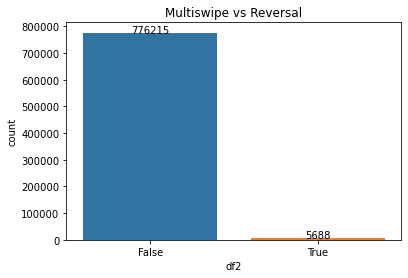

In [25]:
graph = sns.countplot(result_df['df2'])
graph.set_xticklabels(graph.get_xticklabels())
graph.set_title("Multiswipe vs Reversal")
i=0
for p in graph.patches:
    height = p.get_height()
    graph.text(p.get_x()+p.get_width()/2., height + 0.1,
        result_df['df2'].value_counts()[i],ha="center")
    i += 1

In [26]:
result_df['multiswipe'].value_counts()#Count of values

False    768557
True      13346
Name: multiswipe, dtype: int64

In [27]:
total_multiswipe['transactionAmount'].describe()

count    13346.000000
mean       144.131205
std        149.843272
min          0.000000
25%         36.900000
50%         98.400000
75%        200.560000
max       1394.190000
Name: transactionAmount, dtype: float64

Text(0, 0.5, 'Count')

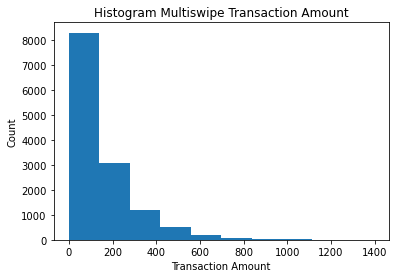

In [28]:
plt.hist(total_multiswipe['transactionAmount'])
plt.title("Histogram Multiswipe Transaction Amount")
plt.xlabel("Transaction Amount")
plt.ylabel("Count")

In [29]:
total_reversal['transactionAmount'].describe()

count    20187.000000
mean       138.957512
std        147.773961
min          0.000000
25%         33.410000
50%         92.010000
75%        192.970000
max       1435.640000
Name: transactionAmount, dtype: float64

Text(0, 0.5, 'Count')

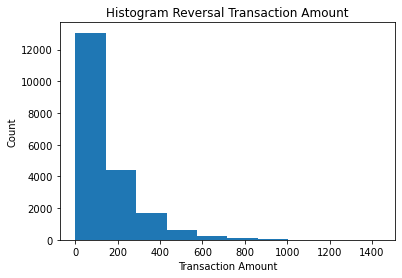

In [30]:
plt.hist(total_reversal['transactionAmount'])
plt.title("Histogram Reversal Transaction Amount")
plt.xlabel("Transaction Amount")
plt.ylabel("Count")

In [31]:
#Checking statistical value 
import statistics as stat
def stats(a):
    print("Mean:",stat.mean(a))
    print("Median:",stat.median(a))
    print("Mode:",stat.mode(a))
  
print("Transaction Amount")
stats(result_df.transactionAmount)
print("Multiswipe Transaction Amount")
stats(total_multiswipe.transactionAmount)
print("Reversal Transaction Amount")
stats(total_reversal.transactionAmount)

Transaction Amount
Mean: 136.99806854558685
Median: 87.92
Mode: 0.0
Multiswipe Transaction Amount
Mean: 144.13120485538738
Median: 98.4
Mode: 0.0
Reversal Transaction Amount
Mean: 138.95751176499726
Median: 92.01
Mode: 0.0


# Removing missing values

In [32]:
result_df.drop(['df2','transactionDateTime','customerId','df1', 'echoBuffer','merchantCity', 'merchantState', 'merchantZip', 'posOnPremises', 'recurringAuthInd', 'recurringAuthInd'], axis=1, inplace=True)
for col in result_df.columns:
    if (result_df[col].eq('').any() == True):
        result_df.drop(result_df[result_df[col].eq('')].index, inplace = True)

# Exploratory Data Analysis

Text(0, 0.5, 'Count')

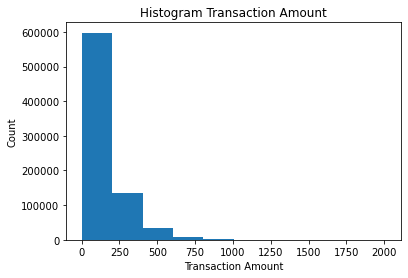

In [33]:
plt.hist(result_df.transactionAmount)
plt.title("Histogram Transaction Amount")
plt.xlabel("Transaction Amount")
plt.ylabel("Count")

D:\Anaconda\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, 'Distribution Plot')

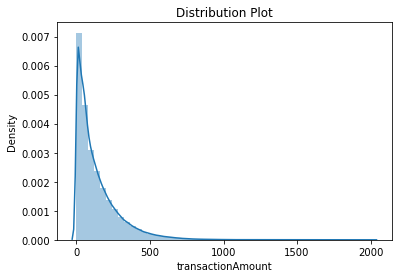

In [34]:
sns.distplot(result_df.transactionAmount).set_title("Distribution Plot")

Text(0.5, 1.0, 'Boxplot Transaction Amount')

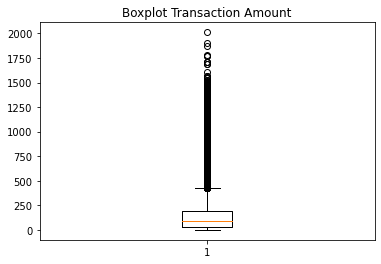

In [35]:
plt.boxplot(result_df['transactionAmount'])
plt.title("Boxplot Transaction Amount")

D:\Anaconda\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


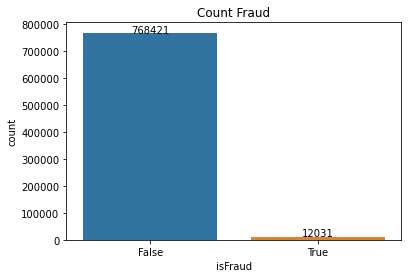

In [36]:
graph = sns.countplot(result_df.isFraud)
graph.set_xticklabels(graph.get_xticklabels())
graph.set_title("Count Fraud")
i=0
for p in graph.patches:
    height = p.get_height()
    graph.text(p.get_x()+p.get_width()/2., height + 0.1,
        result_df['isFraud'].value_counts()[i],ha="center")
    i += 1

D:\Anaconda\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


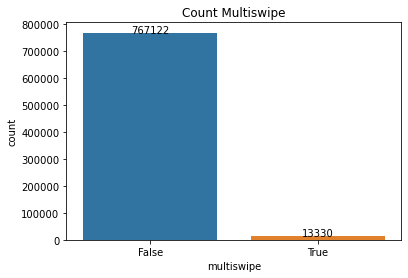

In [37]:
graph = sns.countplot(result_df['multiswipe'])
graph.set_xticklabels(graph.get_xticklabels())
graph.set_title("Count Multiswipe")
i=0
for p in graph.patches:
    height = p.get_height()
    graph.text(p.get_x()+p.get_width()/2., height + 0.1,
        result_df['multiswipe'].value_counts()[i],ha="center")
    i += 1

D:\Anaconda\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


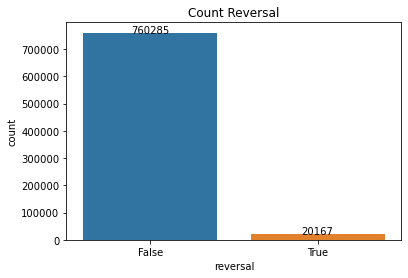

In [38]:
graph = sns.countplot(result_df['reversal'])
graph.set_xticklabels(graph.get_xticklabels())
graph.set_title("Count Reversal")
i=0
for p in graph.patches:
    height = p.get_height()
    graph.text(p.get_x()+p.get_width()/2., height + 0.1,
        result_df['reversal'].value_counts()[i],ha="center")
    i += 1

D:\Anaconda\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


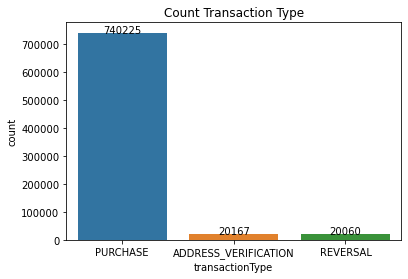

In [39]:
graph = sns.countplot(result_df['transactionType'])
graph.set_xticklabels(graph.get_xticklabels())
graph.set_title("Count Transaction Type")
i=0
for p in graph.patches:
    height = p.get_height()
    graph.text(p.get_x()+p.get_width()/2., height + 0.1,
        result_df['transactionType'].value_counts()[i],ha="center")
    i += 1

D:\Anaconda\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


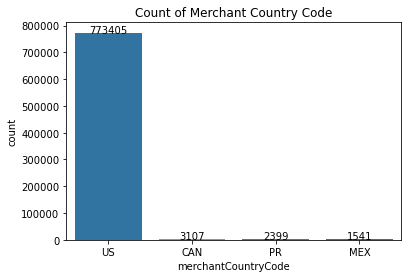

In [40]:
graph = sns.countplot(result_df.merchantCountryCode)
graph.set_xticklabels(graph.get_xticklabels())
graph.set_title("Count of Merchant Country Code")
i=0
for p in graph.patches:
    height = p.get_height()
    graph.text(p.get_x()+p.get_width()/2., height + 0.1,
        result_df['merchantCountryCode'].value_counts()[i],ha="center")
    i += 1

D:\Anaconda\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


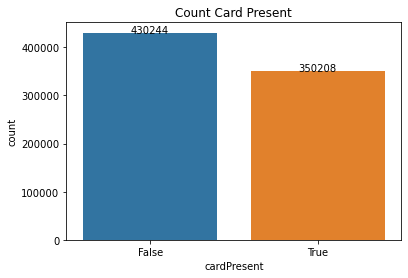

In [41]:
graph = sns.countplot(result_df.cardPresent)
graph.set_xticklabels(graph.get_xticklabels())
graph.set_title("Count Card Present")
i=0
for p in graph.patches:
    height = p.get_height()
    graph.text(p.get_x()+p.get_width()/2., height + 0.1,
        result_df['cardPresent'].value_counts()[i],ha="center")
    i += 1

Text(0.5, 0.98, 'Fraud vs Card Present')

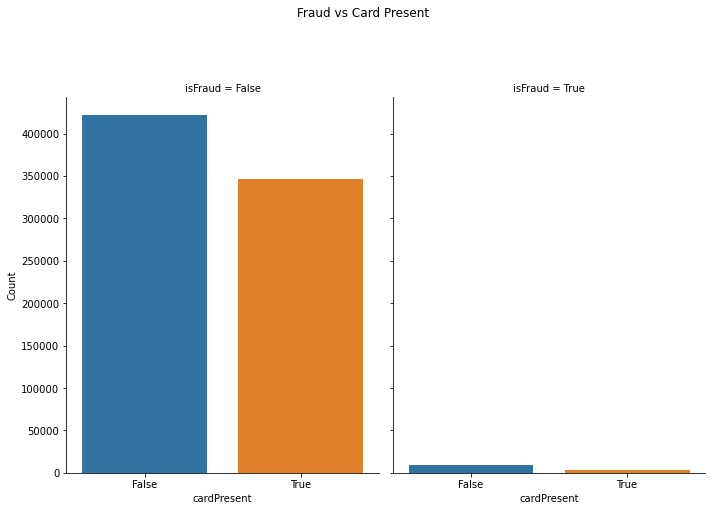

In [42]:
a=result_df.groupby(['cardPresent','isFraud']).size().sort_values(ascending=False).reset_index(name='Count')
graph = sns.catplot(x="cardPresent", y="Count",col="isFraud",
                data=a, kind="bar",
                height=7, aspect=.7);
graph.fig.subplots_adjust(top=0.8)
graph.fig.suptitle("Fraud vs Card Present")

Text(0.5, 0.98, 'Merchant Country Code vs Card Present')

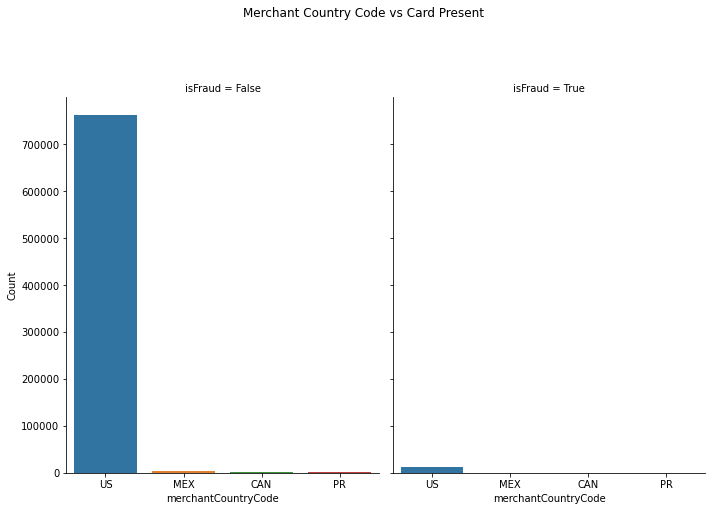

In [43]:
b=result_df.groupby(['merchantCountryCode','isFraud']).size().sort_values(ascending=False).reset_index(name='Count')
graph = sns.catplot(x="merchantCountryCode", y="Count",col="isFraud",
                data=b, kind="bar",
                height=7, aspect=.7);
graph.fig.subplots_adjust(top=0.8)
graph.fig.suptitle("Merchant Country Code vs Card Present")

# Data Pre-processing

In [44]:
#Converting boolean values to binary
for col in result_df.columns:
    if(result_df[col].astype(str).str.contains('True').sum()>0 and result_df[col].astype(str).str.contains('False').sum()>0):
        result_df.loc[result_df[col].astype(str).str.contains('True'), col] = 1
        result_df.loc[result_df[col].astype(str).str.contains('False'), col] = 0
print(result_df.info)

<bound method DataFrame.info of         accountNumber  creditLimit  availableMoney  transactionAmount  \
0           737265056       5000.0         5000.00              98.55   
1           737265056       5000.0         5000.00              74.51   
2           737265056       5000.0         5000.00               7.47   
3           737265056       5000.0         5000.00               7.47   
4           830329091       5000.0         5000.00              71.18   
...               ...          ...             ...                ...   
786358      732852505      50000.0        48904.96             119.92   
786359      732852505      50000.0        48785.04              18.89   
786360      732852505      50000.0        48766.15              49.43   
786361      732852505      50000.0        48716.72              49.89   
786362      732852505      50000.0        48666.83              72.18   

               merchantName acqCountry merchantCountryCode  posEntryMode  \
0              

In [45]:
#Converting distinct values using label encoding
from sklearn.preprocessing import LabelEncoder
obj_col = []
for col in result_df.columns: 
    if(result_df[col].dtype == object):
        obj_col.append(col)
           
labelencoder = LabelEncoder()
for i in obj_col:
    result_df[i] = labelencoder.fit_transform(result_df[i].astype(str))   
print(result_df.info)

<bound method DataFrame.info of         accountNumber  creditLimit  availableMoney  transactionAmount  \
0           737265056       5000.0         5000.00              98.55   
1           737265056       5000.0         5000.00              74.51   
2           737265056       5000.0         5000.00               7.47   
3           737265056       5000.0         5000.00               7.47   
4           830329091       5000.0         5000.00              71.18   
...               ...          ...             ...                ...   
786358      732852505      50000.0        48904.96             119.92   
786359      732852505      50000.0        48785.04              18.89   
786360      732852505      50000.0        48766.15              49.43   
786361      732852505      50000.0        48716.72              49.89   
786362      732852505      50000.0        48666.83              72.18   

        merchantName  acqCountry  merchantCountryCode  posEntryMode  \
0               2085

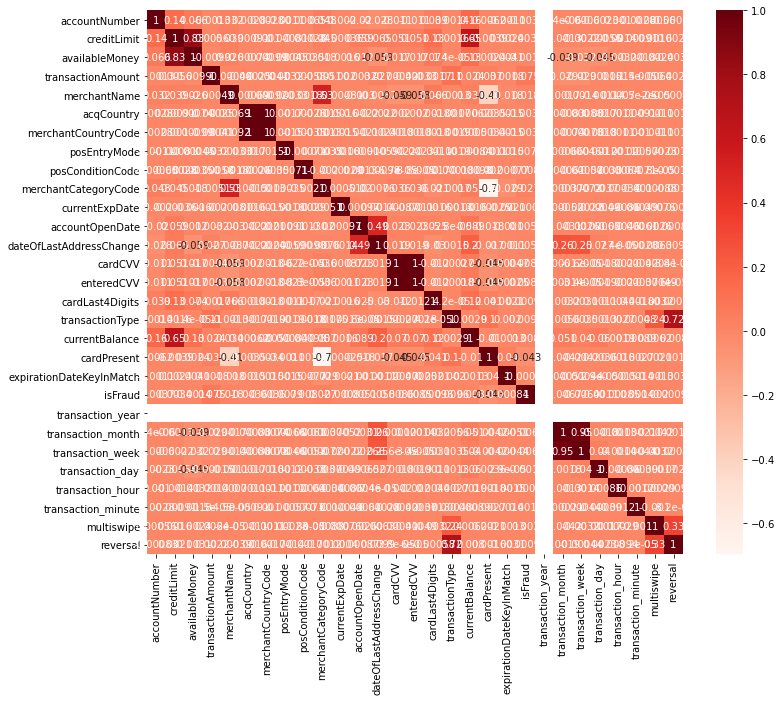

accountNumber               0.003743
creditLimit                 0.003375
availableMoney              0.001417
transactionAmount           0.074607
merchantName                0.017589
acqCountry                  0.003628
merchantCountryCode         0.003645
posEntryMode                0.007869
posConditionCode            0.007992
merchantCategoryCode        0.027290
currentExpDate              0.000797
accountOpenDate             0.005149
dateOfLastAddressChange     0.005846
cardCVV                     0.008568
enteredCVV                  0.008537
cardLast4Digits             0.000960
transactionType             0.009636
currentBalance              0.008029
cardPresent                 0.042588
expirationDateKeyInMatch    0.000844
isFraud                     1.000000
transaction_month           0.006664
transaction_week            0.006359
transaction_day             0.001073
transaction_hour            0.000847
transaction_minute          0.001412
multiswipe                  0.001968
r

In [46]:
#Using Pearson Correlation
plt.figure(figsize=(12,10))
cor = result_df.corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
plt.show()
#Correlation with output variable
cor_target = abs(cor["isFraud"])
#Selecting highly correlated features
relevant_features = cor_target[cor_target>0]
print(relevant_features)

# Train/Test set

In [47]:
#Segrigating Features and Target variable
x=result_df.drop('isFraud',axis=1)
y=result_df['isFraud']

In [48]:
#Distributing data in train test
from sklearn.model_selection import train_test_split
train_features, test_features, train_labels, test_labels = train_test_split(x, y, test_size = 0.3, random_state = 42)

In [49]:
print('Training Features Shape:', train_features.shape)
print('Training Labels Shape:', train_labels.shape)
print('Testing Features Shape:', test_features.shape)
print('Testing Labels Shape:', test_labels.shape)

Training Features Shape: (546316, 28)
Training Labels Shape: (546316,)
Testing Features Shape: (234136, 28)
Testing Labels Shape: (234136,)


# Model Building

# Logistic Regression

In [50]:
import timeit
start = timeit.default_timer()
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from imblearn.over_sampling import SMOTE
nr = SMOTE()
train_features, train_labels = nr.fit_resample(train_features, train_labels)
logreg = LogisticRegression(max_iter=1000)
logreg.fit(train_features, train_labels)
y_pred=logreg.predict(test_features)
print(classification_report(test_labels, y_pred))
stop = timeit.default_timer()
print('Time: ', stop - start)

              precision    recall  f1-score   support

           0       0.98      1.00      0.99    230540
           1       0.00      0.00      0.00      3596

    accuracy                           0.98    234136
   macro avg       0.49      0.50      0.50    234136
weighted avg       0.97      0.98      0.98    234136

Time:  5.443932099999984


D:\Anaconda\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\Anaconda\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\Anaconda\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [51]:
from sklearn.metrics import confusion_matrix, roc_auc_score, accuracy_score, precision_score, recall_score, roc_curve
errors = abs(y_pred - test_labels)
print('Mean Absolute Error:', round(np.mean(errors), 2), 'degrees.')
cnf_matrix = confusion_matrix(test_labels, y_pred)
print("Confusion Matrix:")
print(cnf_matrix)
print("Accuracy:",accuracy_score(test_labels, y_pred))
print("Precision:",precision_score(test_labels, y_pred))
print("Recall:",recall_score(test_labels, y_pred))

Mean Absolute Error: 0.02 degrees.
Confusion Matrix:
[[230540      0]
 [  3596      0]]
Accuracy: 0.9846414049953873
Precision: 0.0
Recall: 0.0


D:\Anaconda\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0.5064425588594867


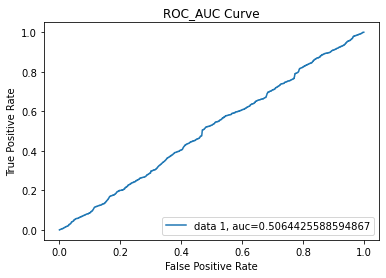

In [52]:
y_pred_proba = logreg.predict_proba(test_features)[::,1]
fpr, tpr, _ = roc_curve(test_labels,  y_pred_proba)
auc = roc_auc_score(test_labels, y_pred_proba)
print(auc)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.title("ROC_AUC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.show()

# GBM

In [53]:
import timeit
start = timeit.default_timer() 
from imblearn.over_sampling import SMOTE
nr = SMOTE()
train_features, train_labels = nr.fit_resample(train_features, train_labels)

In [54]:
from sklearn.ensemble import GradientBoostingClassifier
gbm = GradientBoostingClassifier()
gbm.fit(train_features,train_labels)
predictions = gbm.predict(test_features)
print(classification_report(test_labels, predictions))
stop = timeit.default_timer()
print('Time: ', stop - start)

              precision    recall  f1-score   support

           0       0.99      0.94      0.97    230540
           1       0.06      0.21      0.09      3596

    accuracy                           0.93    234136
   macro avg       0.52      0.58      0.53    234136
weighted avg       0.97      0.93      0.95    234136

Time:  549.2559638


In [55]:
errors = abs(predictions - test_labels)
print('Mean Absolute Error:', round(np.mean(errors), 2), 'degrees.')
print("Accuracy:",accuracy_score(test_labels, predictions))
print("Precision:",precision_score(test_labels, predictions))
print("Recall:",recall_score(test_labels, predictions))
conf = confusion_matrix(test_labels,predictions)
print(conf)

Mean Absolute Error: 0.07 degrees.
Accuracy: 0.9330004783544606
Precision: 0.05661899523285662
Recall: 0.21468298109010012
[[217677  12863]
 [  2824    772]]


0.7002230013626661


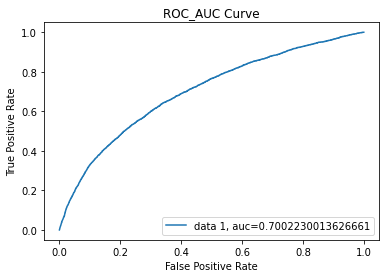

In [56]:
y_pred_proba = gbm.predict_proba(test_features)[::,1]
fpr, tpr, _ = roc_curve(test_labels,  y_pred_proba)
auc = roc_auc_score(test_labels, y_pred_proba)
print(auc)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.title("ROC_AUC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.show()

# Random Forest Classifier

In [57]:
import timeit
start = timeit.default_timer()
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_estimators = 200, random_state=42)
rf.fit(train_features, train_labels)

RandomForestClassifier(n_estimators=200, random_state=42)

In [58]:
predictions = rf.predict(test_features)
print(classification_report(test_labels, predictions))
stop = timeit.default_timer()
print('Time: ', stop - start)

              precision    recall  f1-score   support

           0       0.99      1.00      0.99    230540
           1       0.25      0.10      0.14      3596

    accuracy                           0.98    234136
   macro avg       0.62      0.55      0.57    234136
weighted avg       0.97      0.98      0.98    234136

Time:  833.7271799


In [59]:
errors = abs(predictions - test_labels)
print('Mean Absolute Error:', round(np.mean(errors), 2), 'degrees.')
conf = confusion_matrix(test_labels,predictions)
print("Confusion Matrix:")
print(conf)
print("Accuracy:",accuracy_score(test_labels, predictions))
print("Precision:",precision_score(test_labels, predictions))
print("Recall:",recall_score(test_labels, predictions))

Mean Absolute Error: 0.02 degrees.
Confusion Matrix:
[[229455   1085]
 [  3241    355]]
Accuracy: 0.9815235589571872
Precision: 0.2465277777777778
Recall: 0.09872080088987764


In [60]:
importances = list(rf.feature_importances_)
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(x.columns, importances)]
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True) 
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances];

Variable: posEntryMode         Importance: 0.26
Variable: transactionAmount    Importance: 0.12
Variable: posConditionCode     Importance: 0.1
Variable: cardPresent          Importance: 0.06
Variable: merchantName         Importance: 0.04
Variable: accountNumber        Importance: 0.03
Variable: merchantCategoryCode Importance: 0.03
Variable: accountOpenDate      Importance: 0.03
Variable: cardLast4Digits      Importance: 0.03
Variable: currentBalance       Importance: 0.03
Variable: transaction_month    Importance: 0.03
Variable: transaction_hour     Importance: 0.03
Variable: creditLimit          Importance: 0.02
Variable: availableMoney       Importance: 0.02
Variable: currentExpDate       Importance: 0.02
Variable: dateOfLastAddressChange Importance: 0.02
Variable: cardCVV              Importance: 0.02
Variable: enteredCVV           Importance: 0.02
Variable: transaction_week     Importance: 0.02
Variable: transaction_day      Importance: 0.02
Variable: transaction_minute   Importa

0.8145672495190236


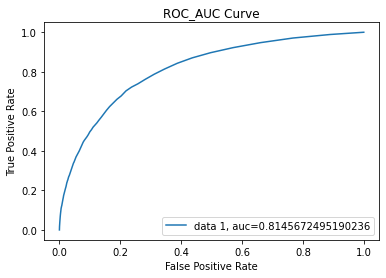

In [61]:
y_pred_proba = rf.predict_proba(test_features)[::,1]
fpr, tpr, _ = roc_curve(test_labels,  y_pred_proba)
auc = roc_auc_score(test_labels, y_pred_proba)
print(auc)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.title("ROC_AUC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.show()

# Sequential Model

In [67]:
from keras import Sequential
from keras.layers import Dense

In [68]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
x = sc.fit_transform(x)
train_features, test_features, train_labels, test_labels = train_test_split(x, y, test_size = 0.3)

In [69]:
nr = SMOTE()
train_features, train_labels = nr.fit_resample(train_features, train_labels)
print('Training Features Shape:', train_features.shape)
print('Training Labels Shape:', train_labels.shape)
print('Testing Features Shape:', test_features.shape)
print('Testing Labels Shape:', test_labels.shape)
def build_model():    
    classifier = Sequential()
    classifier.add(Dense(6, activation='relu', kernel_initializer='random_normal', input_dim=28))
    classifier.add(Dense(6, activation='relu', kernel_initializer='random_normal'))
    classifier.add(Dense(1, activation='sigmoid', kernel_initializer='random_normal'))
    classifier.compile(optimizer ='adam',loss='binary_crossentropy', metrics =['accuracy'])
    return classifier

Training Features Shape: (1075790, 28)
Training Labels Shape: (1075790,)
Testing Features Shape: (234136, 28)
Testing Labels Shape: (234136,)


In [71]:
start = timeit.default_timer()
keras_model = build_model()
keras_model.fit(train_features,train_labels, batch_size=64, epochs=30)
print('Time: ', stop - start)

Epoch 1/30
16810/16810 [==============================] - 12s 630us/step - loss: 0.6087 - accuracy: 0.6682
Epoch 2/30
16810/16810 [==============================] - 11s 636us/step - loss: 0.5837 - accuracy: 0.6913
Epoch 3/30
16810/16810 [==============================] - 12s 707us/step - loss: 0.5798 - accuracy: 0.6936
Epoch 4/30
16810/16810 [==============================] - 16s 941us/step - loss: 0.5770 - accuracy: 0.6963
Epoch 5/30
16810/16810 [==============================] - 13s 783us/step - loss: 0.5743 - accuracy: 0.6993
Epoch 6/30
16810/16810 [==============================] - 13s 761us/step - loss: 0.5725 - accuracy: 0.7006
Epoch 7/30
16810/16810 [==============================] - 14s 805us/step - loss: 0.5717 - accuracy: 0.7015
Epoch 8/30
16810/16810 [==============================] - 13s 773us/step - loss: 0.5706 - accuracy: 0.7030
Epoch 9/30
16810/16810 [==============================] - 13s 768us/step - loss: 0.5705 - accuracy: 0.7034
Epoch 10/30
16810/16810 [============

In [72]:
eval_model=keras_model.evaluate(train_features, train_labels)
eval_model

33619/33619 [==============================] - 17s 491us/step - loss: 0.5687 - accuracy: 0.7050


[0.5686637759208679, 0.7050130367279053]

In [75]:
from sklearn import metrics
print("Accuracy:",metrics.accuracy_score(test_labels, y_pred))
print("Precision:",metrics.precision_score(test_labels, y_pred))
print("Recall:",metrics.recall_score(test_labels, y_pred))
cm = confusion_matrix(test_labels, y_pred)
print(cm)

Accuracy: 0.9845816106878054
Precision: 0.0
Recall: 0.0


D:\Anaconda\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[[230526      0]
 [  3610      0]]


In [76]:
y_pred_keras = keras_model.predict(test_features).ravel()
fpr_keras, tpr_keras, thresholds_keras = roc_curve(test_labels, y_pred_keras)
auc_keras = auc(fpr_keras, tpr_keras)
plt.plot(fpr_keras,tpr_keras,label="data 1, auc="+str(auc_keras))
plt.legend(loc=4)
plt.title("ROC_AUC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.show()

TypeError: 'numpy.float64' object is not callable